# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from utils import *

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
    corners = corners.squeeze()
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for u,v in corners:
        z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, y, z])
        
    return np.array(obj_pts)

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    # Estimate the extrinsic matrix
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
    retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)
    
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Homogeneous Coordinates
    H = np.eye(4)
    H[:3,:3] = rotation_matrix
    H[:3,-1] = tvec.T
    
    # Camera Pose
    T = np.linalg.inv(H)
    return T
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

# Loading of Data

## Pickle Data

In [3]:
filename = 'pantilt_baseline_sweep_pickle_20240319_020402_085007.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'pantilt_baseline_sweep',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



In [6]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()
pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [7]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [8]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_left_pan_cmd_tminus1',
       'theta_right_pan_cmd_tminus1', 'theta_tilt_cmd_tminus1',
       'chess_idx_tminus1', 'theta_left_pan_tminus1',
       'theta_right_pan_tminus1', 'theta_tilt_tminus1',
       'plan_phi_left_pan_tminus2', 'plan_phi_r

# Filtering

In [9]:
filt_df = pickle_df[(pickle_df['theta_left_pan_cmd']>-13) & (pickle_df['theta_left_pan_cmd']<13) ].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.439453,-11.689453,0.263672,374.415405,82.553940,344.089996,209.459641,341.577301,220.849014,...,0.263672,-0.191072,-0.259080,-0.046732,-0.077717,-0.138835,-0.008162,1,1,1
1,8,0.527344,-10.722656,0.263672,504.482849,80.876587,456.561554,211.356262,451.990723,225.322235,...,0.263672,0.041399,-0.020434,-0.006353,0.155831,0.094958,-0.004544,3,3,3
2,4,1.494141,-9.667969,0.263672,504.485016,80.864151,438.480927,211.352844,432.561035,225.174377,...,0.263672,0.272912,0.206403,-0.036965,0.155831,0.094958,-0.004544,2,2,1
3,0,2.548828,-8.701172,0.263672,374.428009,82.554832,296.609589,209.140167,286.830170,220.024658,...,0.263672,0.041399,-0.020434,-0.006353,-0.077717,-0.138835,-0.008162,0,0,0
4,4,3.515625,-7.734375,0.263672,374.422607,82.536232,281.642334,208.979523,270.178070,219.692841,...,0.263672,-0.191166,-0.258933,-0.045722,-0.077717,-0.138835,-0.008162,1,1,1


In [10]:
print(filt_df['theta_left_pan_cmd'].unique())
print(filt_df['theta_right_pan_cmd'].unique())
print(filt_df['theta_tilt_cmd'].unique())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]
[  0.  -5. -10. -15. -20. -25. -30.]


# Extrinsic Matrix

## Initialization

In [11]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

In [12]:
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

In [13]:
# Example

chest_img = filt_df['chest_img'][0]
depth_img = filt_df['depth_img'][0]

In [14]:
# Get Chess Corners and Object Points

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)
obj_pts = get_chess_obj_pts(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)

In [15]:
# Define the 3D coordinates of the chessboard corners in the world coordinate system
chessboard_size = (9, 6)
origin_point = [0,0]
square_size = 0.047  # Assumiimgng each square size is 1 unit
obj_pts = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
obj_pts[:,:2] = (np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) -np.array(origin_point))* square_size

(190.0, 70.0)

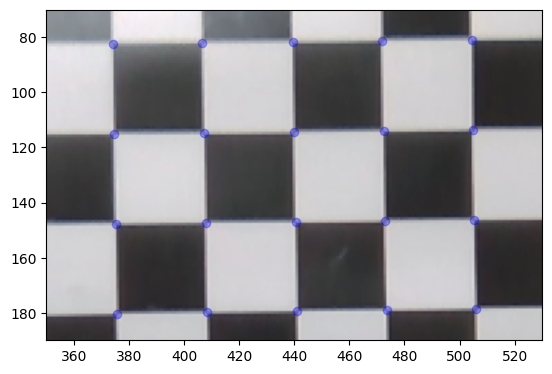

In [16]:
plt.figure()
plt.imshow(chest_img)
for u,v in corners:
    plt.scatter(u,v, color='blue',alpha=0.3)
plt.xlim([350, 530])
plt.ylim([190, 70])

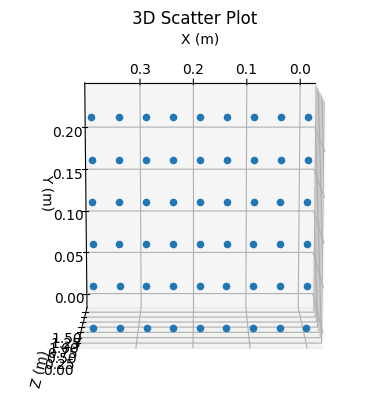

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and an axes object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0])

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Scatter Plot')
ax.set_zlim([-0.2,1.7])
ax.view_init(elev=-80, azim=90)

# Show the plot
plt.show()

# Extrinsic Transformation

In [18]:
# Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

In [19]:
# Looping: Left Eye Image

img_list = filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))

In [20]:
%matplotlib widget

(-0.2, 2.0)

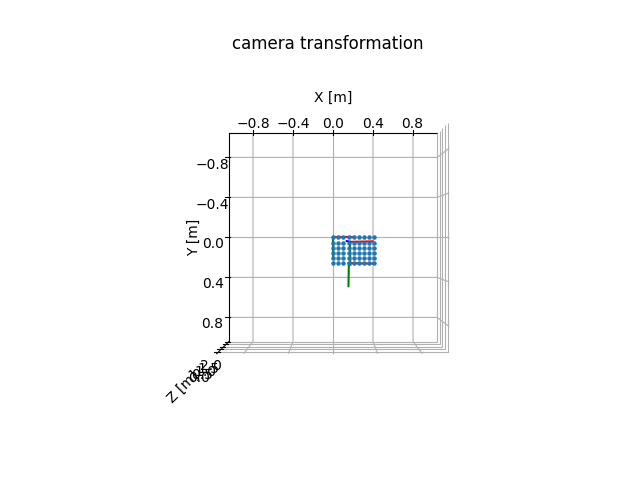

In [21]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest[:3,:3], T_chest[:3,-1], s=0.2)
    
# Plot Left Poses
for T in [T_left_list[0]]:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

In [22]:
T_left_list[0]

array([[ 0.99079682,  0.01651125, -0.13434674,  0.14710231],
       [-0.02112258,  0.99923307, -0.03297135,  0.03849932],
       [ 0.1336993 ,  0.03550566,  0.9903857 , -0.86054739],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [23]:
T_chest

array([[ 0.99937142, -0.01760985,  0.03076796,  0.13765699],
       [ 0.01736354,  0.99981517,  0.00825445,  0.22309464],
       [-0.03090763, -0.00771502,  0.99949247, -0.86660825],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [24]:
# Compute inverse of P1
P1_inv = np.linalg.inv(T_chest)

# Compute the relative transformation between P1 and P2
P_rel = np.matmul(P1_inv, T_left_list[0])

print(P_rel)

[[ 0.98567493  0.0327537  -0.16544527  0.00604682]
 [-0.03959795  0.99848369 -0.03824028 -0.18477428]
 [ 0.16394189  0.04424378  0.98547732  0.00482467]
 [ 0.          0.          0.          1.        ]]


## Multiple Poses

(-0.2, 2.0)

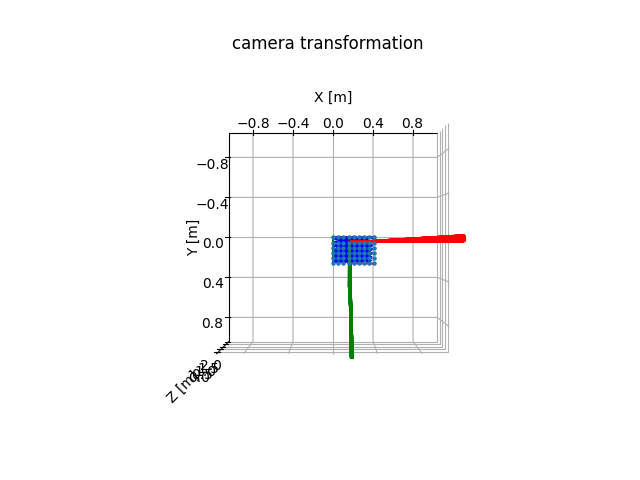

In [25]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest[:3,:3], T_chest[:3,-1], s=0.2)
    
# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

# Extrinsic Pose (Right)

In [26]:
# Looping: Left Eye Image

img_list = filt_df['right_eye_img'].tolist()
T_right_list = []
for img in img_list:
    T_right_list.append(get_camera_pose(img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))

(-0.2, 2.0)

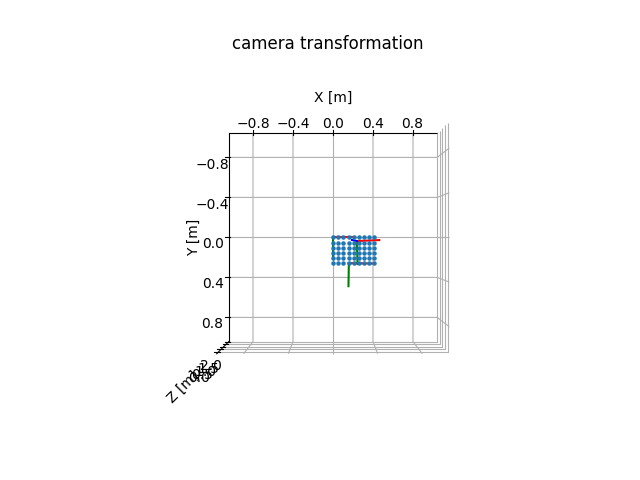

In [27]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest[:3,:3], T_chest[:3,-1], s=0.2)
    
# Plot Right Poses
for T in [T_right_list[0]]:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

In [28]:
T_right_list[0]

array([[ 0.97945753,  0.03258675, -0.19900014,  0.20648251],
       [-0.04254626,  0.99803602, -0.04597737,  0.03179521],
       [ 0.19711106,  0.05349959,  0.97892034, -0.85926399],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [29]:
T_chest

array([[ 0.99937142, -0.01760985,  0.03076796,  0.13765699],
       [ 0.01736354,  0.99981517,  0.00825445,  0.22309464],
       [-0.03090763, -0.00771502,  0.99949247, -0.86660825],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [30]:
# Compute inverse of P1
P1_inv = np.linalg.inv(T_chest)

# Compute the relative transformation between P1 and P2
P_rel = np.matmul(P1_inv, T_right_list[0])

print(P_rel)

[[ 0.97201086  0.04824216 -0.2299295   0.06523363]
 [-0.06130721  0.99686495 -0.0500169  -0.19253274]
 [ 0.22679573  0.06271331  0.97192116  0.00787909]
 [ 0.          0.          0.          1.        ]]


## Multiple Poses

(-0.2, 2.0)

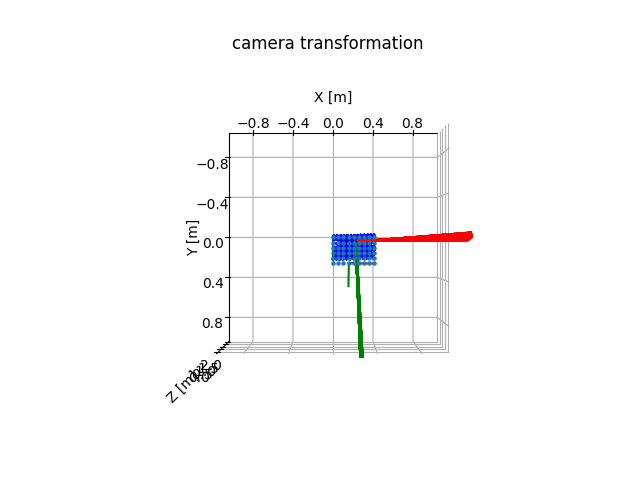

In [31]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest[:3,:3], T_chest[:3,-1], s=0.2)
    
# Plot Right Poses
for T in T_right_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

## List of Camera Pose

In [ ]:
# New Camera Matrix

left_eye_camera_mtx = np.array([[611.3656616210938, 0.0, 320.4515075683594], 
                                [0.0, 609.9281616210938, 247.3879852294922], 
                                [0.0, 0.0, 1.0]])
left_eye_dist_coef = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

right_eye_camera_mtx = np.array([[611.3656616210938, 0.0, 320.4515075683594], 
                                [0.0, 609.9281616210938, 247.3879852294922], 
                                [0.0, 0.0, 1.0]])
right_eye_dist_coef = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
# Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

In [ ]:
# Looping: Left Eye Image

# img_list = pan_filt_df['left_eye_img'].tolist()

# Realsense Eye Image
filename = '20240226_014111_517237_left_eye.png'
left_img_path = os.path.join(os.getcwd(), 'results', 'pan_baseline_fk_acc_zero',filename)
left_img = cv2.imread(left_img_path)
img_list = [left_img]

T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))

In [ ]:
# Looping: Right Eye Image

# img_list = pan_filt_df['right_eye_img'].tolist()

# Realsense Eye Image
filename = '20240226_014048_435364_right_eye.png'
right_img_path = os.path.join(os.getcwd(), 'results', 'pan_baseline_fk_acc_zero',filename)
right_img = cv2.imread(right_img_path)
img_list = [right_img]

T_right_list = []
for img in img_list:
    T_right_list.append(get_camera_pose(img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))

In [ ]:
%matplotlib widget

In [ ]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest[:3,:3], T_chest[:3,-1], s=0.2)
    
# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)
# Plot Right Poses
for T in T_right_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

In [ ]:
T_chest

In [ ]:
T_left_list[0]

In [ ]:
T_right_list[0]

In [ ]:
# Compute inverse of P1
P1_inv = np.linalg.inv(T_chest)

# Compute the relative transformation between P1 and P2
P_rel = np.matmul(P1_inv, T_left_list[0])

P_rel[:3,-1]

In [ ]:
# Compute inverse of P1
P1_inv = np.linalg.inv(T_chest)

# Compute the relative transformation between P1 and P2
P_rel = np.matmul(P1_inv, T_right_list[0])

P_rel[:3,-1]

# Coordinate Transformation

In [ ]:
def get_chess_obj_pts_world(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for u,v in corners:
        z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, z, -y])
        
    return np.array(obj_pts)
    
def depth_to_world(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,z,-y

In [ ]:
# Get Chess Corners and Object Points

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)
obj_pts_world = get_chess_obj_pts_world(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)
obj_pts_world = obj_pts

In [ ]:
# Looping: Left Eye Image

# Realsense Eye Image
filename = '20240226_014111_517237_left_eye.png'
left_img_path = os.path.join(os.getcwd(), 'results', 'pan_baseline_fk_acc_zero',filename)
left_img = cv2.imread(left_img_path)
img_list = [left_img]

T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts_world, left_eye_camera_mtx, left_eye_dist_coef))

In [ ]:
# Looping: Right Eye Image

# Realsense Eye Image
filename = '20240226_014048_435364_right_eye.png'
right_img_path = os.path.join(os.getcwd(), 'results', 'pan_baseline_fk_acc_zero',filename)
right_img = cv2.imread(right_img_path)
img_list = [right_img]

T_right_list = []
for img in img_list:
    T_right_list.append(get_camera_pose(img, obj_pts_world, right_eye_camera_mtx, right_eye_dist_coef))

In [ ]:
T_conv = np.zeros((3,3))
T_conv[0,0] = 1
T_conv[1,2] = -1
T_conv[2,1] = 1
T_conv

In [ ]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts_world:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)
# Plot Right Poses
for T in T_right_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)

# ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

# ax.set_zlim([-0.2, 2.0])

In [ ]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts_world:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3]@T_conv, T[:3,-1], s=0.2)
# Plot Right Poses
for T in T_right_list:
    ax = pr.plot_basis(ax, T[:3,:3]@T_conv, T[:3,-1], s=0.2)

# ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

# ax.set_zlim([-0.2, 2.0])

In [ ]:
left_cam_pose_list = []
for T in T_left_list:
    T_temp = T[:3,:3]@T_conv
    T[:3,:3]= T_temp
    left_cam_pose_list.append(T)

In [ ]:
left_loc_list = []
for T in T_left_list:
    left_loc_list.append(T[:3,-1])
left_loc_list = np.array(left_loc_list)
left_loc_list[:5]

In [ ]:
right_loc_list = []
for T in T_right_list:
    right_loc_list.append(T[:3,-1])
right_loc_list = np.array(right_loc_list)
right_loc_list[:5]

In [ ]:
val = math.dist(left_loc_list[0,:], right_loc_list[0,:])
print('Left Eye - Right Eye Distance:', val, 'm')

In [ ]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in left_loc_list:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

# ax.set_zlim([-0.2, 2.0])

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,0])

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,1])

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,2])

# Left Eye Optical Center and Gaze Center

In [ ]:
# Center
cx = camera_mtx['left_eye']['camera_matrix'][0][2]
cy = camera_mtx['left_eye']['camera_matrix'][1][2]
gx = calib_params['left_eye']['x_center']
gy = calib_params['left_eye']['y_center']

# Plot
plt.figure()
plt.scatter(cx, cy, color=colors[0])
plt.scatter(gx, gy, color=colors[1])
plt.xlim([0,847])
plt.ylim([399, 0])
plt.legend(['optical center', 'gaze center'])
plt.grid()

# Print
print('cx:', cx)
print('cy:', cy)
print('gx:', gx)
print('gy:', gy)